# Spam Detection with a Transformer Model (TensorFlow)

This notebook builds a **Transformer-based spam detector** trained on a
custom spam/ham dataset.  
We will cover:

- Data loading  
- Text preprocessing  
- Tokenization and padding  
- Data visualization  
- Model building (Transformer encoder)  
- Training & evaluation  
- Testing the model  

Let's begin!


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, LayerNormalization
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load Dataset
The dataset is a `.txt` file where each line begins with:

- `ham:` for normal emails  
- `spam:` for spam emails  

We read the data, separate text and labels, and convert them into Pandas Series.


In [2]:
with open("spam_emails", "r") as file:
    data = file.readlines()

x = []
y = []
for line in data:
    if line.startswith("ham"):
        x.append(line[4:].strip())
        y.append(0)
    else:
        x.append(line[5:].strip())
        y.append(1)

x = pd.Series(x)
y = pd.Series(y)


# Data Exploration & Visualization
Let's explore the dataset to understand spam/ham distribution.


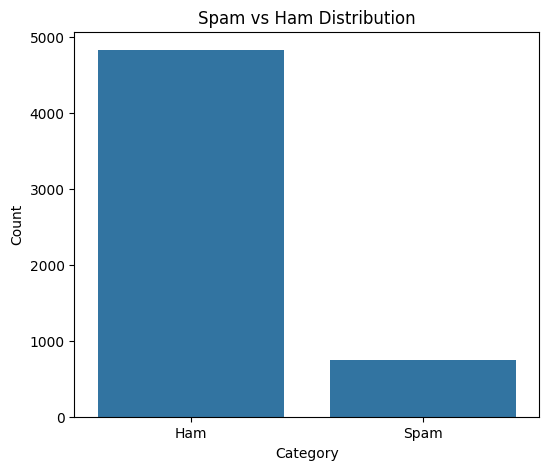

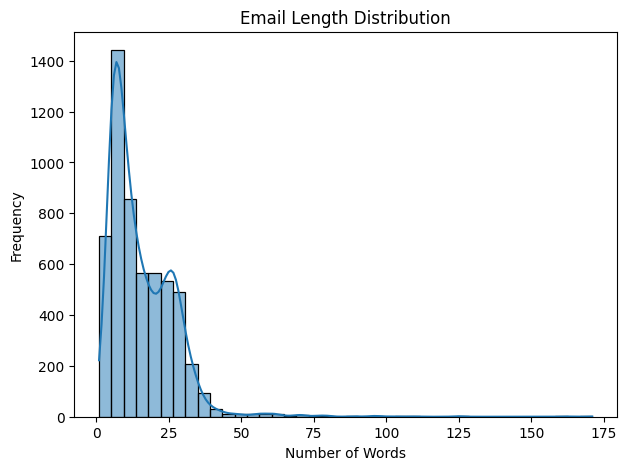

In [3]:
plt.figure(figsize=(6,5))
sns.countplot(x=y.map({0:"Ham",1:"Spam"}))
plt.title("Spam vs Ham Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

email_lengths = x.apply(lambda t: len(t.split()))

plt.figure(figsize=(7,5))
sns.histplot(email_lengths, bins=40, kde=True)
plt.title("Email Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()



# Text Preprocessing
We apply:

- Optional stopword removal  
- Lemmatization  
- Tokenization  
- Sequence padding  

A function is created to handle everything in one place.


In [4]:
def text_processing(x, remove_stopwords, lemmatize, max_len):
    import nltk
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    if remove_stopwords:
        nltk.download("stopwords")
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words("english"))
        x = x.apply(lambda t: " ".join(w for w in t.split() if w.lower() not in stop_words))

    if lemmatize:
        nltk.download("wordnet")
        nltk.download("omw-1.4")
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        x = x.apply(lambda t: " ".join(lemmatizer.lemmatize(w) for w in t.split()))

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    padded = pad_sequences(sequences, maxlen=max_len, padding="post")

    return sequences, padded, tokenizer


# Apply Preprocessing
We set a maximum sequence length and preprocess the text.


In [5]:
max_len = 250
x_seq, x_padded, tokenizer = text_processing(x, remove_stopwords=False, lemmatize=True, max_len=max_len)


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


# Train-Test Split
We split 80% for training and 20% for testing.


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_padded, y, train_size=0.8)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


# Transformer Model
A simple Transformer encoder is built manually:

- Embedding layer  
- Positional encoding  
- Multi-head attention  
- Layer normalization  
- Dense layers  


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
d_model = 256

inputs = layers.Input(shape=(max_len,))

x = layers.Embedding(vocab_size, d_model)(inputs)

positions = tf.range(start=0, limit=max_len, delta=1)
pos_embed = layers.Embedding(input_dim=max_len, output_dim=d_model)(positions)
pos_embed = tf.expand_dims(pos_embed, axis=0)
x = x + pos_embed

attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=d_model)(x, x)
x = layers.LayerNormalization()(x + attn_output)

x = layers.Dense(128, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = Dense(2, activation="softmax")(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()


# Train the Model
We use:

- Loss: sparse categorical crossentropy  
- Optimizer: Adam  
- Metrics: Accuracy  


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=3, batch_size=32, validation_data=(x_test, y_test))


# Training Curves
Let's visualize accuracy and loss during training.


In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Over Epochs")
plt.legend(["Train","Validation"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Over Epochs")
plt.legend(["Train","Validation"])

plt.show()


# Evaluate the Model


In [ ]:
model.evaluate(x_test, y_test)


# Save the model

In [ ]:
model.save("spam_detection_model.keras")

In [ ]:
with open("tokenizer.pkl",'w') as f:
    pickle.dump(tokenizer,f)

# Load the model

In [ ]:
model=tf.keras.models.load_model("spam_detection_model.keras")
with open("tokenizer.pkl",'rb') as f:
    tokenizer=pickle.load(f)

# Email Prediction Function
We preprocess the email → convert to sequence → pad → predict.


In [9]:
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

labels = ["ham", "spam"]

def predict_email(email):
    email = " ".join(lemmatizer.lemmatize(w) for w in email.split())
    seq = tokenizer.texts_to_sequences([email])
    padded = pad_sequences(seq, maxlen=max_len, padding="post")
    pred = model.predict(padded)
    return labels[np.argmax(pred)]


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


# Test the Model


In [10]:
text = """
Congratulations!  
You have been selected to win a brand-new iPhone 15 Pro!

Click the link below to claim your reward before it expires:
http://free-gifts-2025.com/winner

This offer is available only for 24 hours.
Do not miss your chance!
""" # Spam email
print("Prediction:", predict_email(text))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Prediction: spam


In [11]:
text="""
Just a quick reminder about our meeting tomorrow at 10 AM.
Let me know if you need me to bring any documents.
""" # Ham email
print("Prediction:", predict_email(text))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: ham


In [ ]:
import gradio as gr
intfac=gr.Interface(
    inputs="text",
    outputs="text",
    description="Enter your email here ",
    fn=predict_email
)
intfac.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
